# Load library and MCMC results 

In [7]:
library(ggplot2)
library(reshape2) # melt
library(tidyverse)

# load MCMC results 
# already after burn-in
load("basad_beta_Z.RData")
# rename
beta_MCMC <- beta; rm(beta)

# get MCMC's distribution of SSE's
load("SSE_train.RData")
# rename
SSE_MCMC <- SSE; rm(SSE)

# Load training and test sets

In [3]:
# read dataset from csv
train_input <- read_csv("pria_rmi_cv/file_0.csv")
for(i in 1:4){
  filename <- paste0("pria_rmi_cv/file_",i,".csv")
  train_input <- rbind( train_input, read_csv(file = filename) )
}
test_input <- read_csv("pria_prospective.csv")

# specify parameters
p <- 1024
n_train <- nrow(train_input)
n_test <- nrow(test_input) 

# function to process dataset
list_func <- function(input_df){
  # convert character string to columns of predictors and standardize column-wise
  X <- unname( t( sapply( input_df$Fingerprints, function(x){ as.numeric(str_split_fixed(x,"",p)) } ) ) )
  colnames(X) <- paste0("x", 1:p)
  X <- scale(X)
  
  # center or standardize Y 
  Y <- as.numeric(scale(input_df$Keck_Pria_Continuous))
  # Y <- input_df$Keck_Pria_Continuous - mean(input_df$Keck_Pria_Continuous)
  
  # get list
  return(list(
    X = X,
    Y = Y
  ))
}

train_list <- list_func(train_input)
test_list <- list_func(test_input)
rm(train_input, test_input)

Parsed with column specification:
cols(
  Molecule = col_character(),
  SMILES = col_character(),
  Fingerprints = col_character(),
  Keck_Pria_AS_Retest = col_double(),
  Keck_Pria_FP_data = col_double(),
  Keck_Pria_Continuous = col_double(),
  Keck_RMI_cdd = col_double(),
  `FP counts % inhibition` = col_double()
)

Parsed with column specification:
cols(
  Molecule = col_character(),
  SMILES = col_character(),
  Fingerprints = col_character(),
  Keck_Pria_AS_Retest = col_double(),
  Keck_Pria_FP_data = col_double(),
  Keck_Pria_Continuous = col_double(),
  Keck_RMI_cdd = col_double(),
  `FP counts % inhibition` = col_double()
)

Parsed with column specification:
cols(
  Molecule = col_character(),
  SMILES = col_character(),
  Fingerprints = col_character(),
  Keck_Pria_AS_Retest = col_double(),
  Keck_Pria_FP_data = col_double(),
  Keck_Pria_Continuous = col_double(),
  Keck_RMI_cdd = col_double(),
  `FP counts % inhibition` = col_double()
)

Parsed with column specification:
col

# Load some user-defined functions

In [4]:
# ggplot function for density plot
dens_plot.func <- function(MCMC_vec, RW1_vec, RW2_vec, RW3_vec, xlab){
  df <- data.frame(
    method = rep(c("MCMC", "RW_scheme1", "RW_scheme2", "RW_scheme3"), 
                 times = c(length(MCMC_vec), length(RW1_vec), length(RW2_vec), length(RW3_vec))),
    value = c(MCMC_vec, RW1_vec, RW2_vec, RW3_vec)
  )
  ggplot(df, aes(x=value, color=method)) +
    geom_density() + 
    labs(x = xlab)
}

# ggplot function for density histogram
hist_plot.func <- function(MCMC_vec, RW1_vec, xlab){
  df <- data.frame(
    method = rep(c("MCMC", "RW_scheme1"), 
                 times = c(length(MCMC_vec), length(RW1_vec))),
    value = c(MCMC_vec, RW1_vec)
  )
  ggplot(df, aes(x=value, color=method, fill=method)) +
    geom_histogram(aes(y=..density..), alpha=0.5, position="identity", bins = 70) + 
    labs(x = xlab)
}

# plot to compare lines
plot.func <- function(MCMC_vec, w1_vec, w2_vec, w3_vec, sort_vec, sort_text, ylab, type="l"){
  iii <- match(sort(sort_vec),sort_vec)
  plot(1:length(MCMC_vec), MCMC_vec[iii], type = type, xaxt = "n", ylab = ylab, main = "", 
       xlab = paste0("variables x1 - x", p, " arranged according to order of ", sort_text) )
  lines(1:length(MCMC_vec), w1_vec[iii], type = type, lty = 2, col = "red")
  lines(1:length(MCMC_vec), w2_vec[iii], type = type, lty = 3, col = "blue")
  lines(1:length(MCMC_vec), w3_vec[iii], type = type, lty = 4, col = "green")
  lines(1:length(MCMC_vec), MCMC_vec[iii], type = type,lty = 1, col = "black")
  legend('topleft', lty = c(1:4), col = c("black", "red", "blue","green"),
         c("MCMC", "RW scheme 1", "RW scheme 2","RW scheme 3"))
}

# Load random-weighting results

In [30]:
# load either one of them for RW samples
# load("RW_Lasso.RData"); load("SSE_RW_train_1se.RData") # based on lambda.1se in cv.glmnet
load("RW_Lasso_lambmin.RData"); load("SSE_RW_train_lambmin.RData") # based on lambda.min in cv.glmnet

# split beta into 3 weighting schemes
beta_RW1 <- RW_beta[,1:p]
beta_RW2 <- RW_beta[, (p+1) : (2*p) ]
beta_RW3 <- RW_beta[, (2*p+1) : (3*p) ]
rm(RW_beta)
colnames(beta_RW1) <- colnames(beta_MCMC)
colnames(beta_RW2) <- colnames(beta_MCMC)
colnames(beta_RW3) <- colnames(beta_MCMC)

# posterior mean
mean_MCMC <- apply(beta_MCMC, 2, mean)
mean_RW1 <- apply(beta_RW1, 2, mean)
mean_RW2 <- apply(beta_RW2, 2, mean)
mean_RW3 <- apply(beta_RW3, 2, mean)

# 95% CI
CI_RW1 <- t( apply(beta_RW1, 2, function(x){
  quantile(x, probs = c(.025,.975))
} ) ) %>% as.data.frame() %>% 
  setNames(., c("lower", "upper")) %>%
  mutate(CI_length = upper - lower)

CI_RW2 <- t( apply(beta_RW2, 2, function(x){
  quantile(x, probs = c(.025,.975))
} ) ) %>% as.data.frame() %>% 
  setNames(., c("lower", "upper")) %>%
  mutate(CI_length = upper - lower)

CI_RW3 <- t( apply(beta_RW3, 2, function(x){
  quantile(x, probs = c(.025,.975))
} ) ) %>% as.data.frame() %>% 
  setNames(., c("lower", "upper")) %>%
  mutate(CI_length = upper - lower)

CI_MCMC <- t( apply(beta_MCMC, 2, function(x){
  quantile(x, probs = c(.025,.975))
} ) ) %>% as.data.frame() %>% 
  setNames(., c("lower", "upper")) %>%
  mutate(CI_length = upper - lower)

# Compare probability of variables being selected

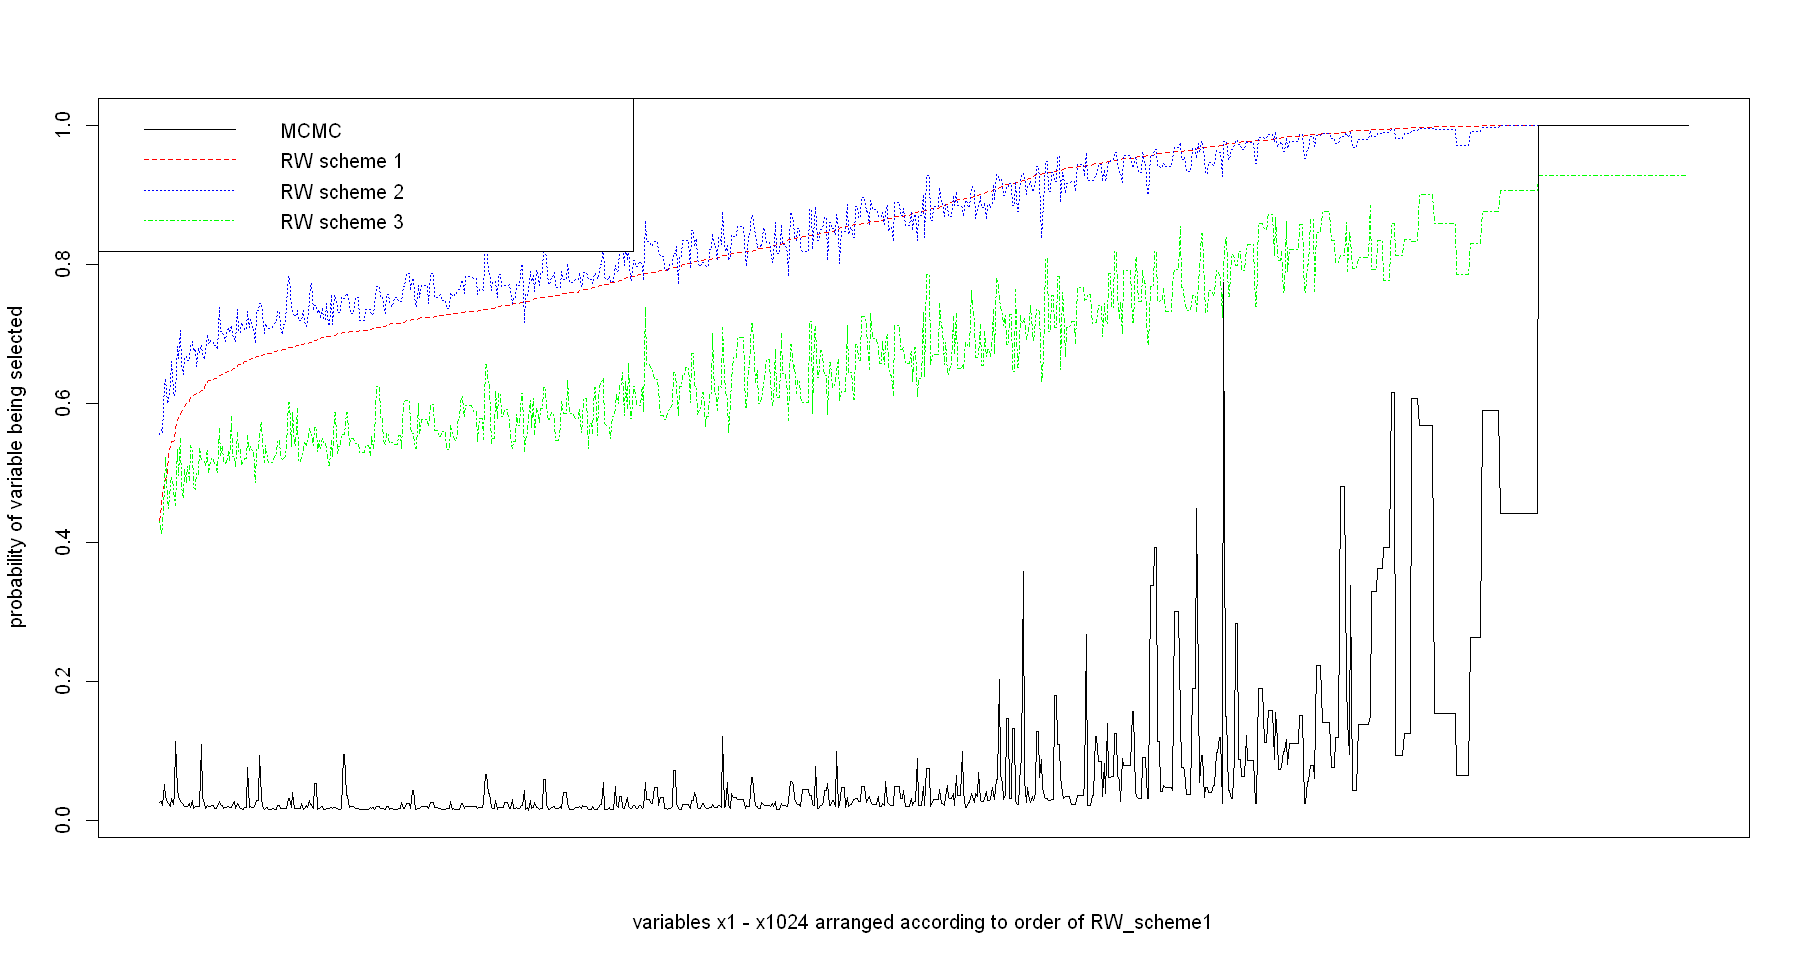

In [10]:
select_MCMC <- apply(Z,2,mean)
select_RW1 <- apply(beta_RW1,2,function(x){
  1 - sum(as.numeric(x == 0))/nrow(beta_RW1)
})
select_RW2 <- apply(beta_RW2,2,function(x){
  1 - sum(as.numeric(x == 0))/nrow(beta_RW2)
})
select_RW3 <- apply(beta_RW3,2,function(x){
  1 - sum(as.numeric(x == 0))/nrow(beta_RW3)
})

options(repr.plot.width=15, repr.plot.height=8)
plot.func(
  MCMC_vec = select_MCMC, 
  w1_vec = select_RW1,
  w2_vec = select_RW2, 
  w3_vec = select_RW3,
  sort_vec = select_RW1,sort_text = "RW_scheme1",
  # sort_vec = select_MCMC,sort_text = "MCMC", 
  ylab = "probability of variable being selected"
)

If we arrange variables according to average probabilities of selecting a variable among the methods:

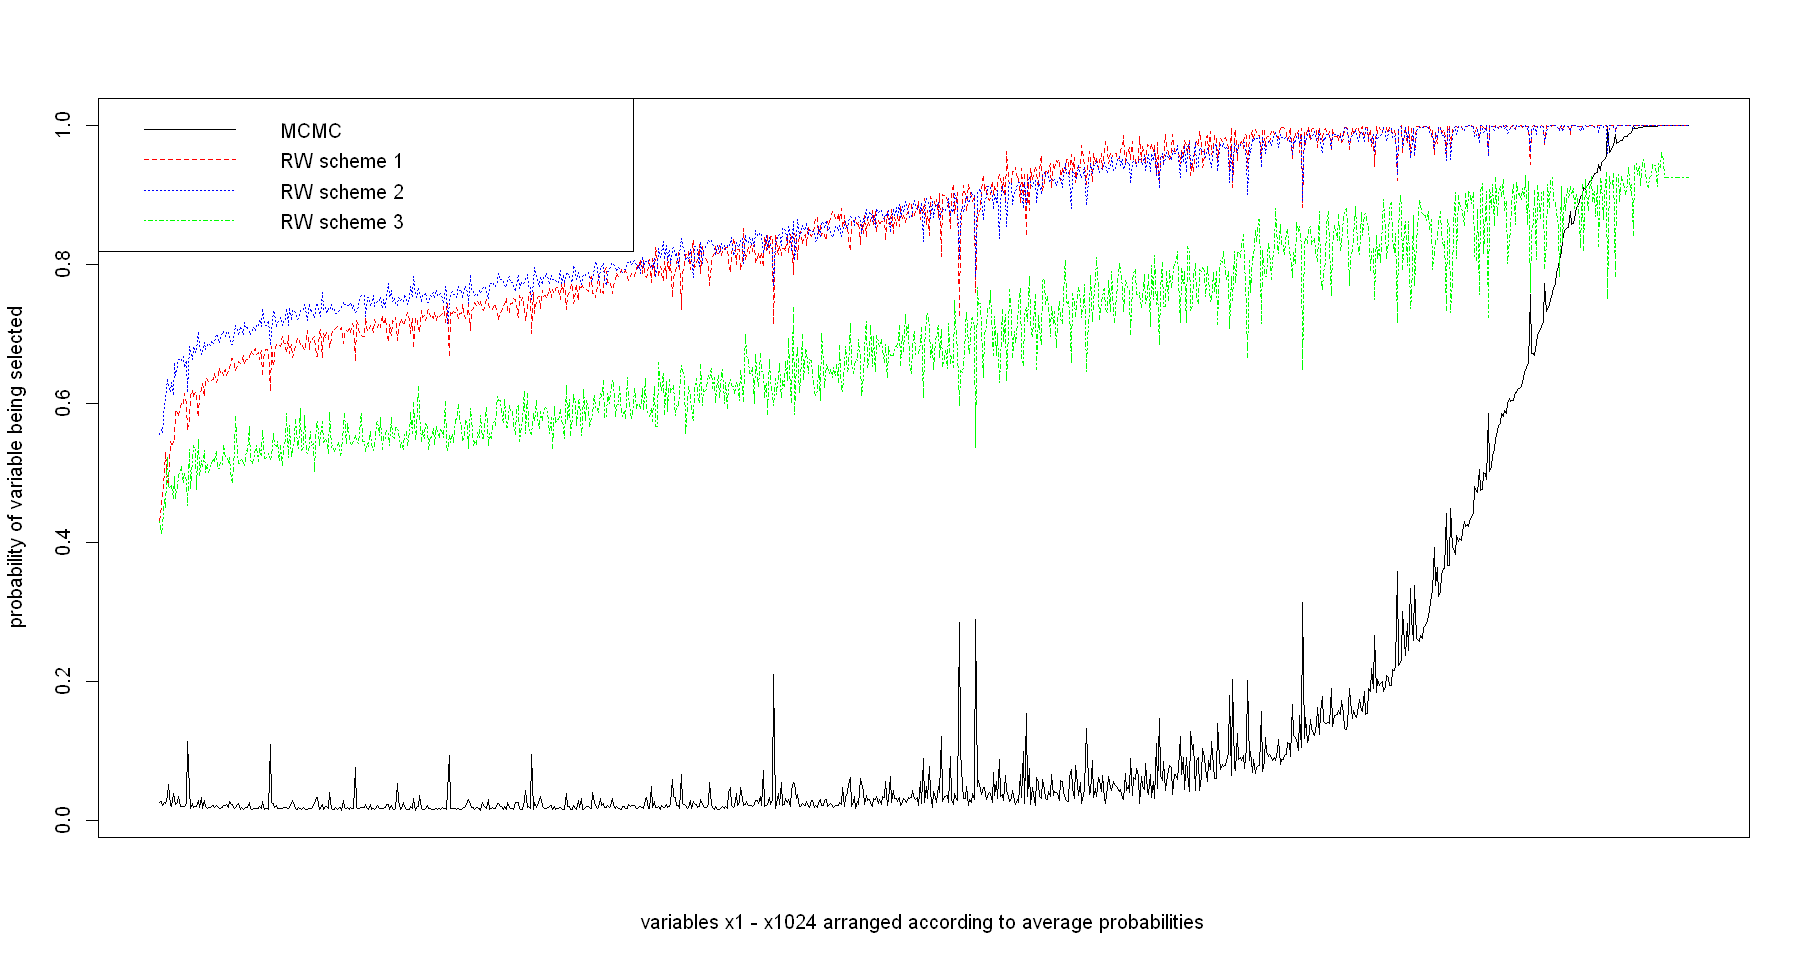

In [36]:
# arrange variables according to average of prob between MCMC and RW1
prob_iii <- match(sort((select_MCMC+select_RW1+select_RW2)/3),
                  (select_MCMC+select_RW1+select_RW2)/3)

options(repr.plot.width=15, repr.plot.height=8)

plot(1:length(select_MCMC), select_MCMC[prob_iii], type = "l", xaxt = "n", 
     ylab = "probability of variable being selected", main = "",  
     xlab = paste0("variables x1 - x", p, " arranged according to average probabilities") )
lines(1:length(select_MCMC), select_RW1[prob_iii], type = "l", lty = 2, col = "red")
lines(1:length(select_MCMC), select_RW2[prob_iii], type = "l", lty = 3, col = "blue")
lines(1:length(select_MCMC), select_RW3[prob_iii], type = "l", lty = 4, col = "green")
legend('topleft', lty = c(1:4), col = c("black", "red", "blue","green"),
       c("MCMC", "RW scheme 1", "RW scheme 2","RW scheme 3"))


# Compare distribution of (adjusted) $R^2$

Warning message:
"Removed 174 rows containing non-finite values (stat_density)."
Warning message:
"Removed 309 rows containing non-finite values (stat_density)."


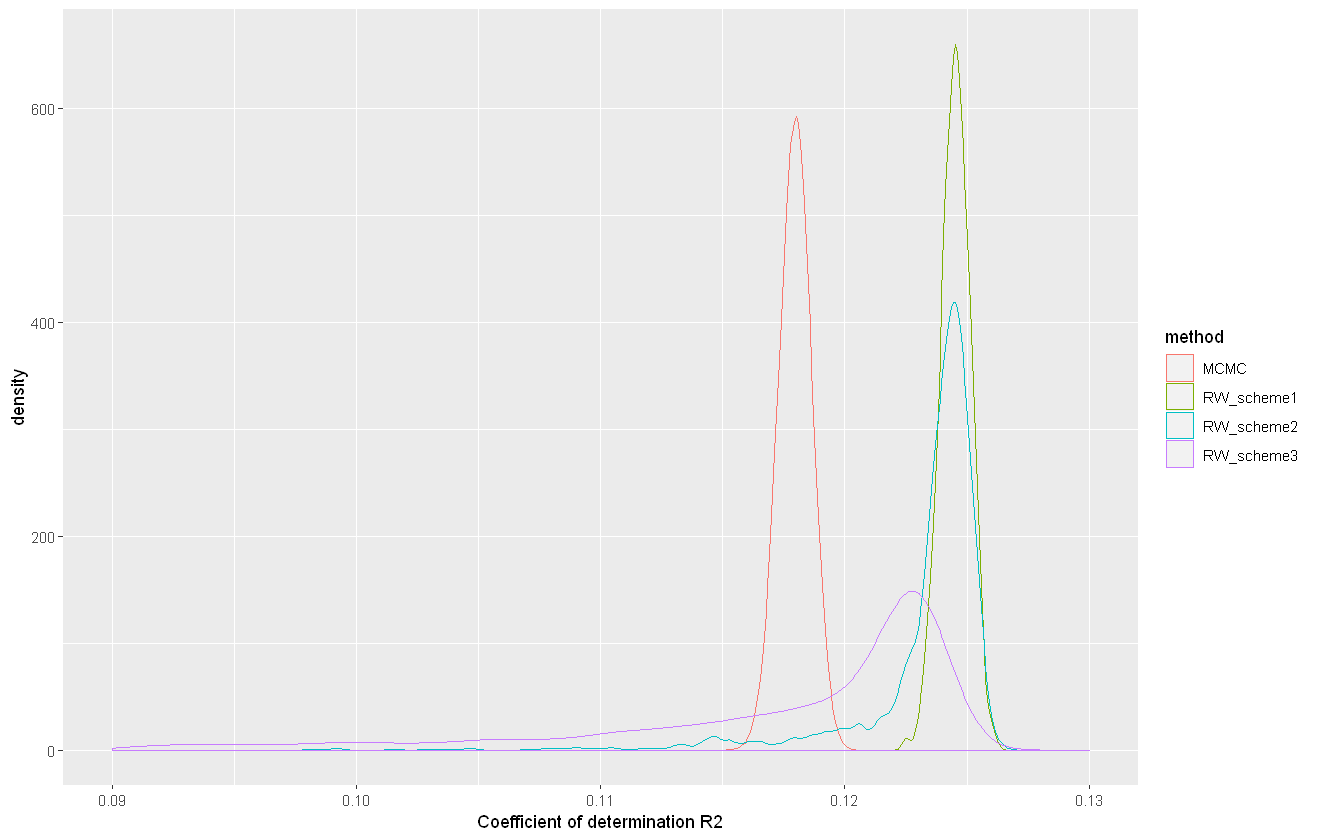

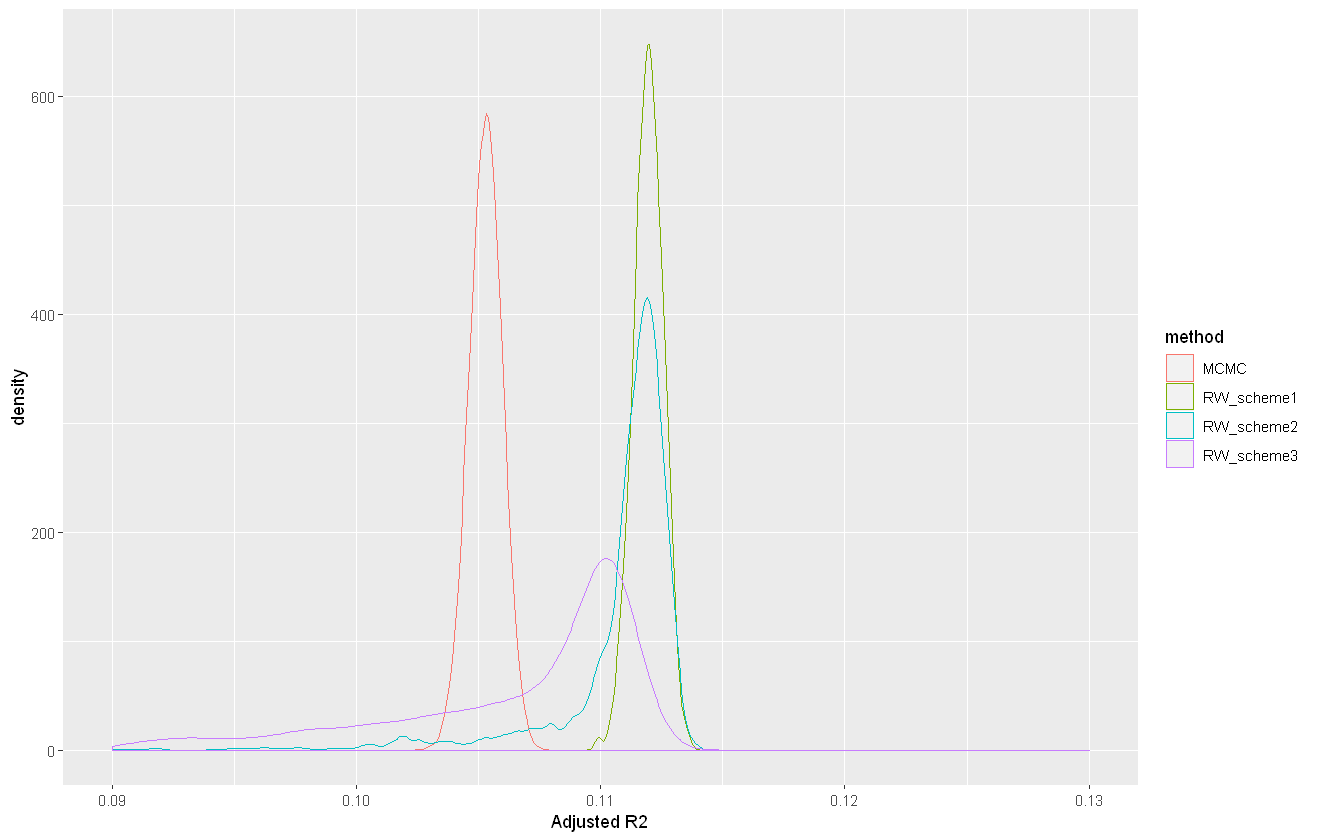

In [24]:
# get distribution of R^2
SSTO <- sum( (train_list$Y - mean(train_list$Y))^2 )
R2_MCMC <- 1 - SSE_MCMC/SSTO
R2_RW1 <- 1 - SSE_RW1/SSTO
R2_RW2 <- 1 - SSE_RW2/SSTO
R2_RW3 <- 1 - SSE_RW3/SSTO

# get distribution of adjusted R^2
R2_adj_MCMC <- 1 - SSE_MCMC/SSTO*(n_train-1)/(n_train-1-p-1)
R2_adj_RW1 <- 1 - SSE_RW1/SSTO*(n_train-1)/(n_train-1-p-1)
R2_adj_RW2 <- 1 - SSE_RW2/SSTO*(n_train-1)/(n_train-1-p-1)
R2_adj_RW3 <- 1 - SSE_RW3/SSTO*(n_train-1)/(n_train-1-p-1)

options(repr.plot.width=11, repr.plot.height=7)

dens_plot.func(
  MCMC_vec = R2_MCMC, 
  RW1_vec = R2_RW1, 
  RW2_vec = R2_RW2, 
  RW3_vec = R2_RW3,
  xlab = "Coefficient of determination R2"
) + xlim(0.09, 0.13)

dens_plot.func(
  MCMC_vec = R2_adj_MCMC, 
  RW1_vec = R2_adj_RW1, 
  RW2_vec = R2_adj_RW2, 
  RW3_vec = R2_adj_RW3,
  xlab = "Adjusted R2"
) + xlim(0.09, 0.13)

If we compare only distributions between MCMC and random-weighting scheme 1, and plot their histograms:

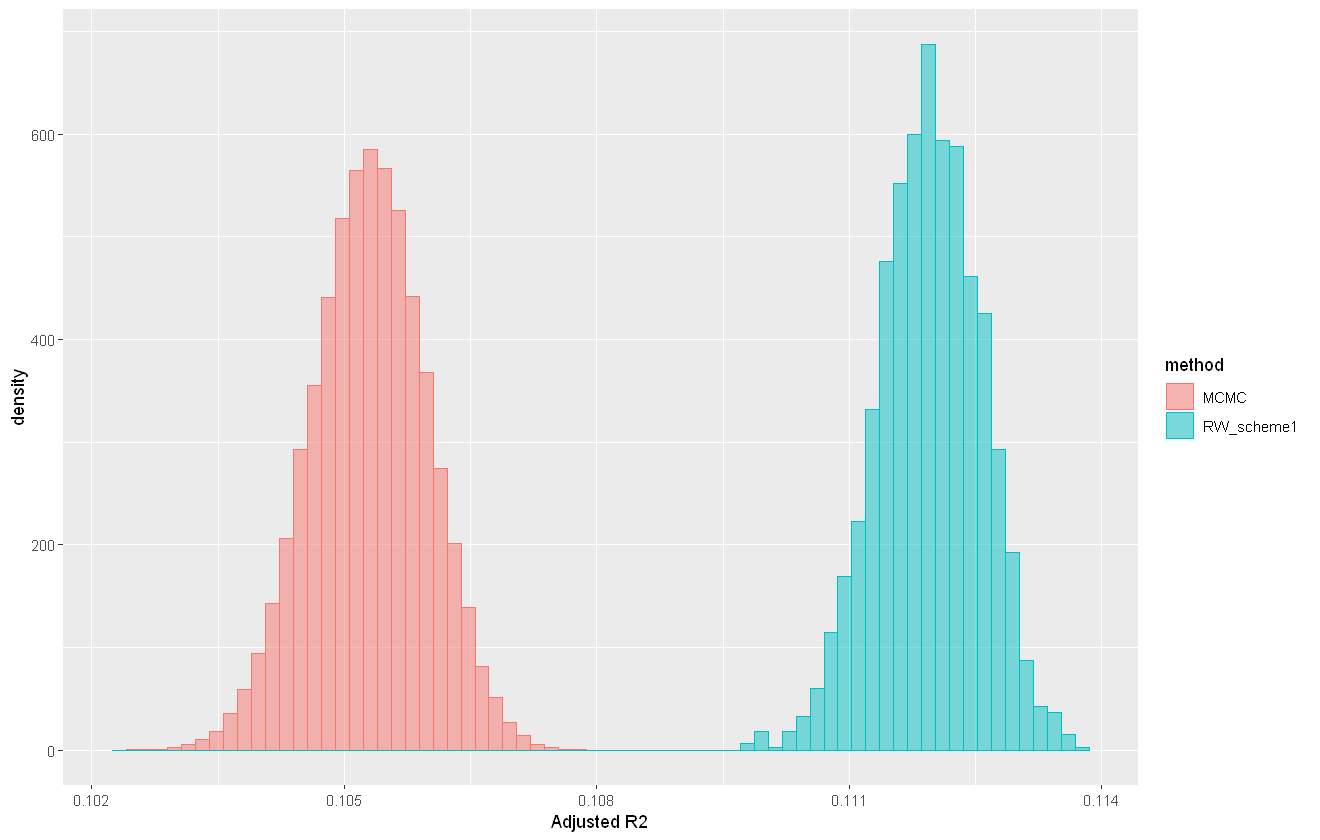

In [25]:
hist_plot.func(
  MCMC_vec = R2_adj_MCMC, 
  RW1_vec = R2_adj_RW1, 
  xlab = "Adjusted R2"
)

# Marginal posterior distributions of coeffs for a few variables

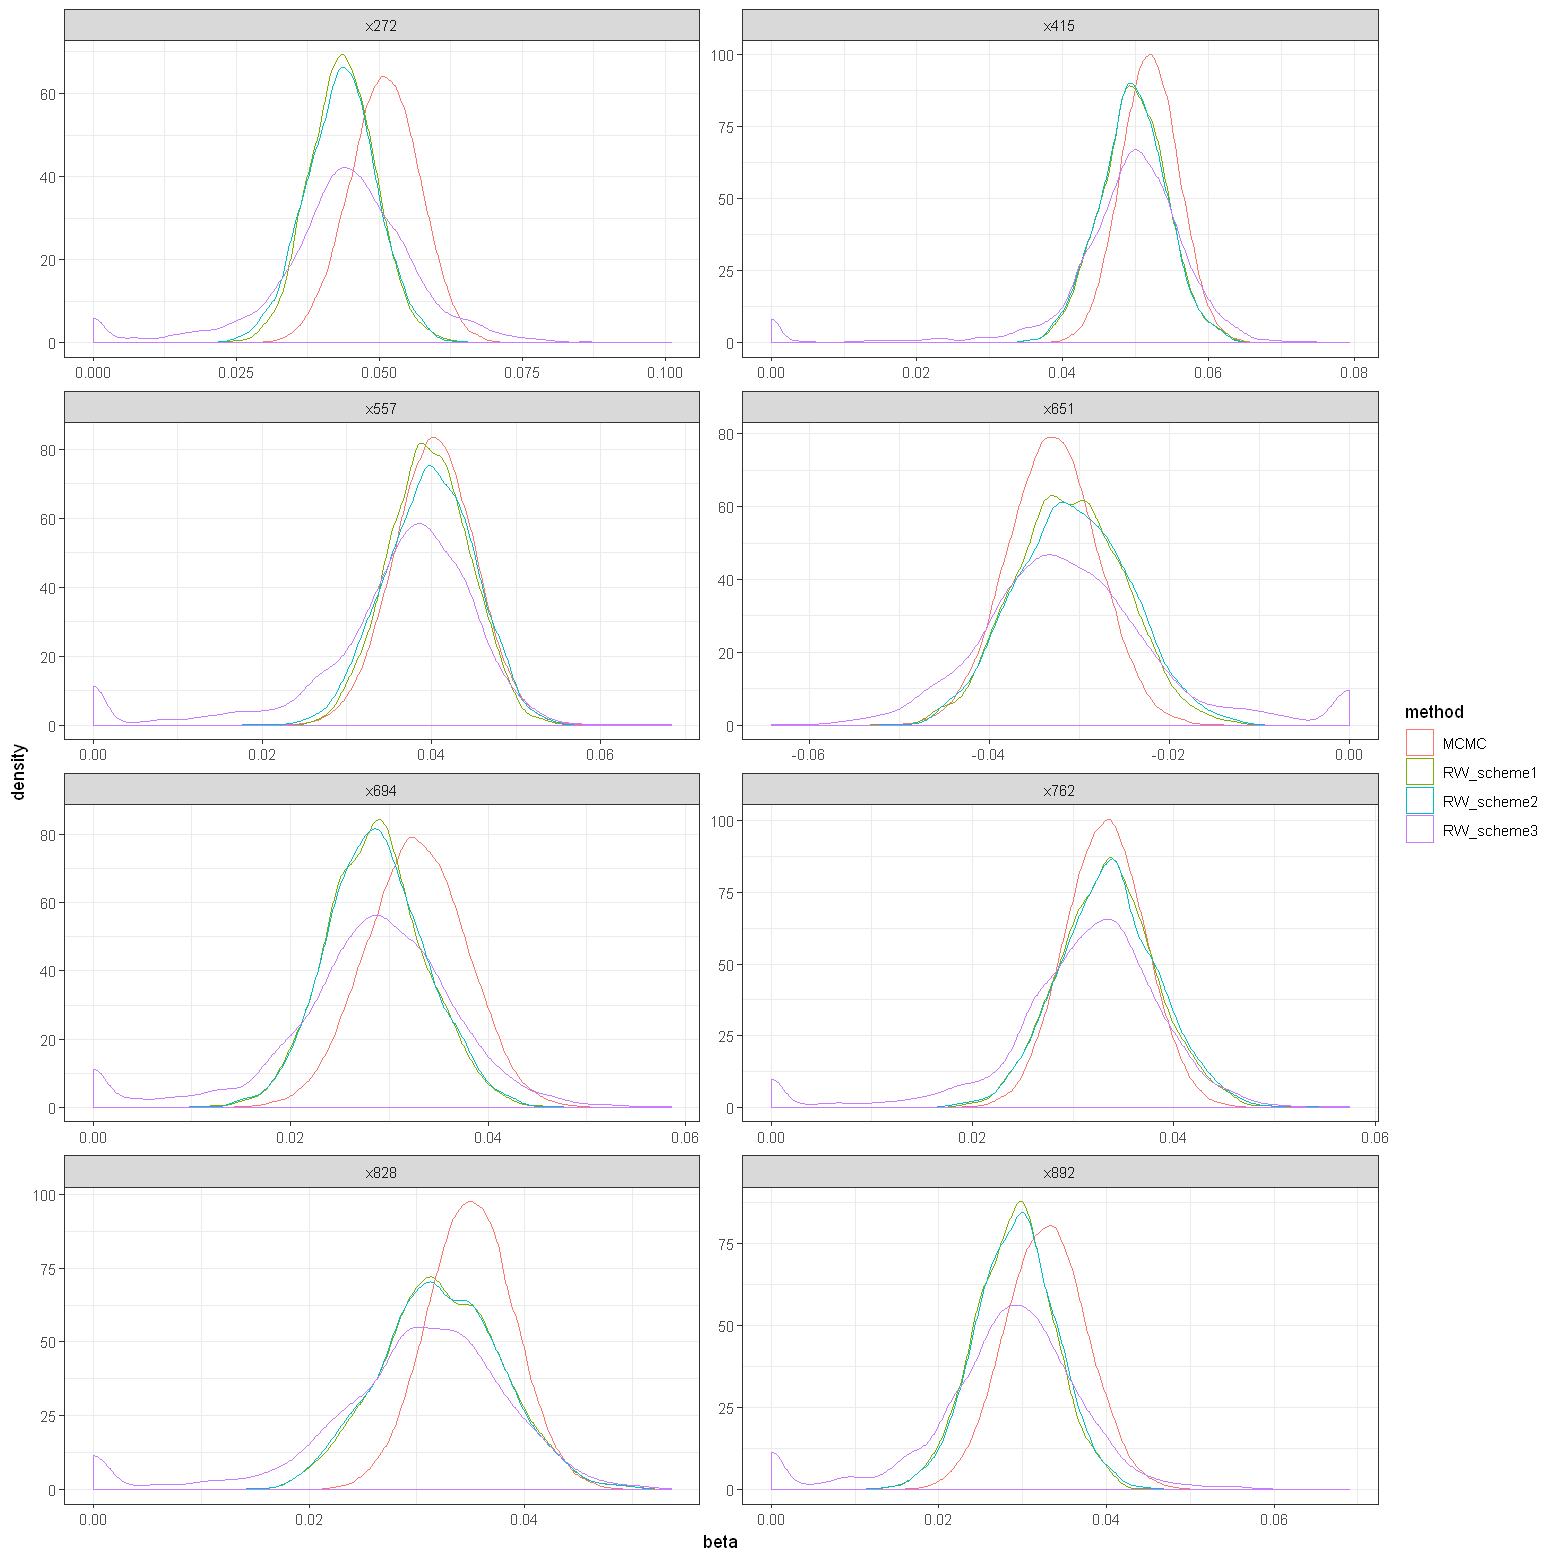

In [21]:
prob_thresh <- .955

theta_ind <- which(
  (select_RW1 >  prob_thresh ) &
    (select_RW2 >  prob_thresh ) &
    (select_RW3 >  prob_thresh ) &
    (select_MCMC >  prob_thresh )
)

df <- rbind(
  melt(beta_RW1[,theta_ind])[,-1],
  melt(beta_RW2[,theta_ind])[,-1],
  melt(beta_RW3[,theta_ind])[,-1],
  melt(beta_MCMC[,theta_ind])[,-1]
)
colnames(df) <- c("variable", "beta")
method = c(
  rep("RW_scheme1",nrow(beta_RW1)*length(theta_ind)),
  rep("RW_scheme2",nrow(beta_RW2)*length(theta_ind)),
  rep("RW_scheme3",nrow(beta_RW3)*length(theta_ind)),
  rep("MCMC",nrow(beta_MCMC)*length(theta_ind))
)
df <- cbind(method, df)

options(repr.plot.width=13, repr.plot.height=13)
ggplot(df, aes(beta,colour = method)) +
  geom_density(alpha = 1) + 
  facet_wrap(~ variable,scales = "free",ncol = 2)+
  theme_bw()

# Posterior mean of coeffs for variables

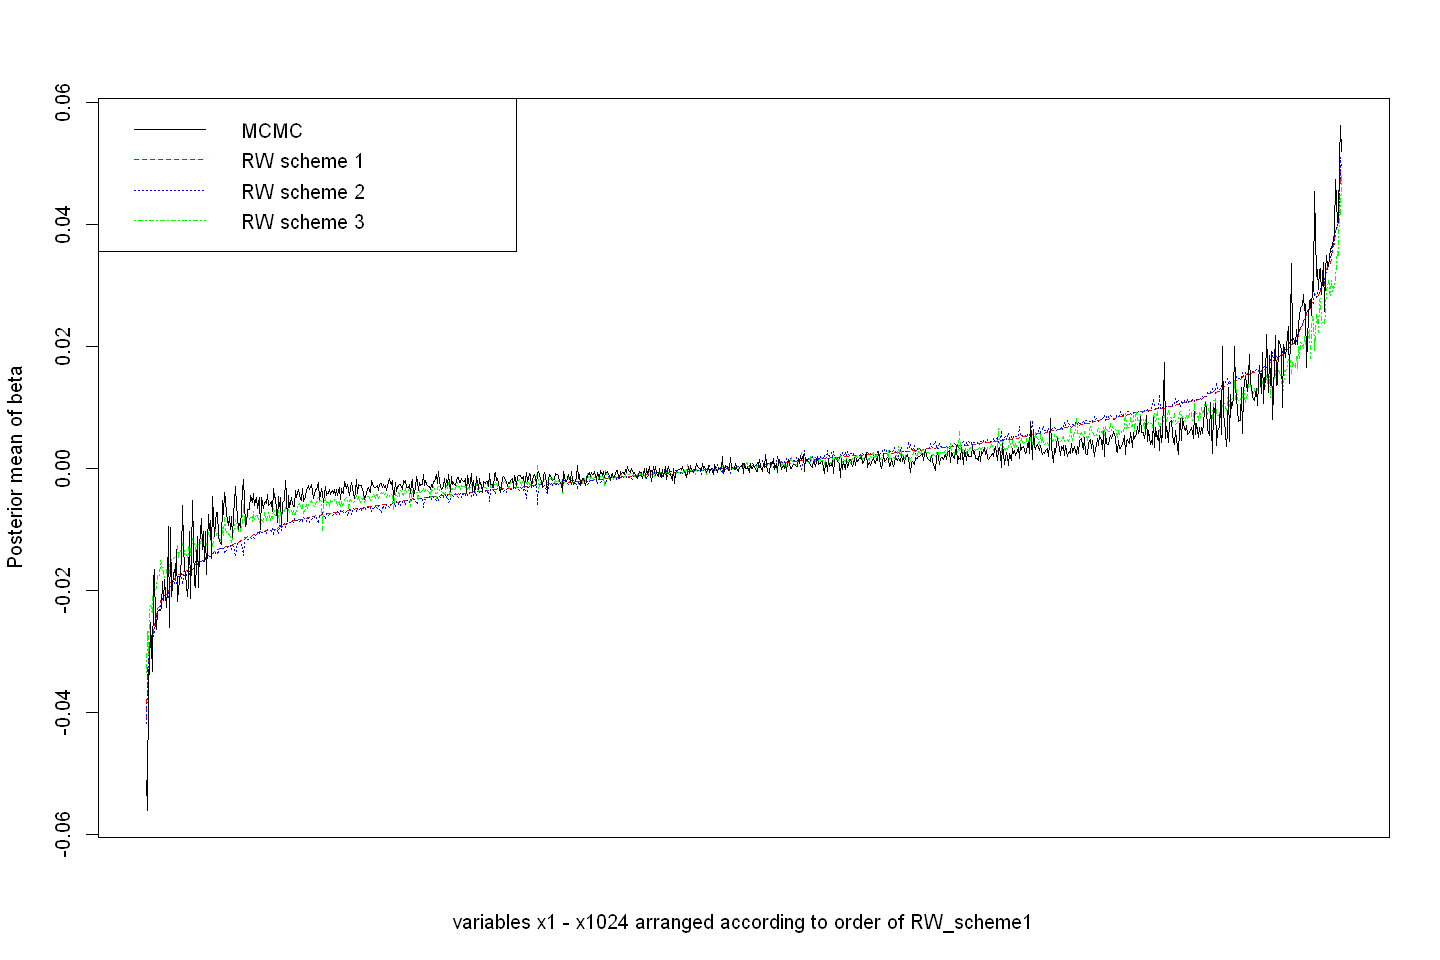

In [23]:
options(repr.plot.width=12, repr.plot.height=8)
plot.func(
  MCMC_vec = mean_MCMC, 
  w1_vec = mean_RW1,
  w2_vec = mean_RW2, 
  w3_vec = mean_RW3,
  sort_vec = mean_RW1, sort_text = "RW_scheme1",
  # sort_vec = mean_MCMC, sort_text = "MCMC", 
  ylab = "Posterior mean of beta"
)

# 95% CI of coeffs for variables

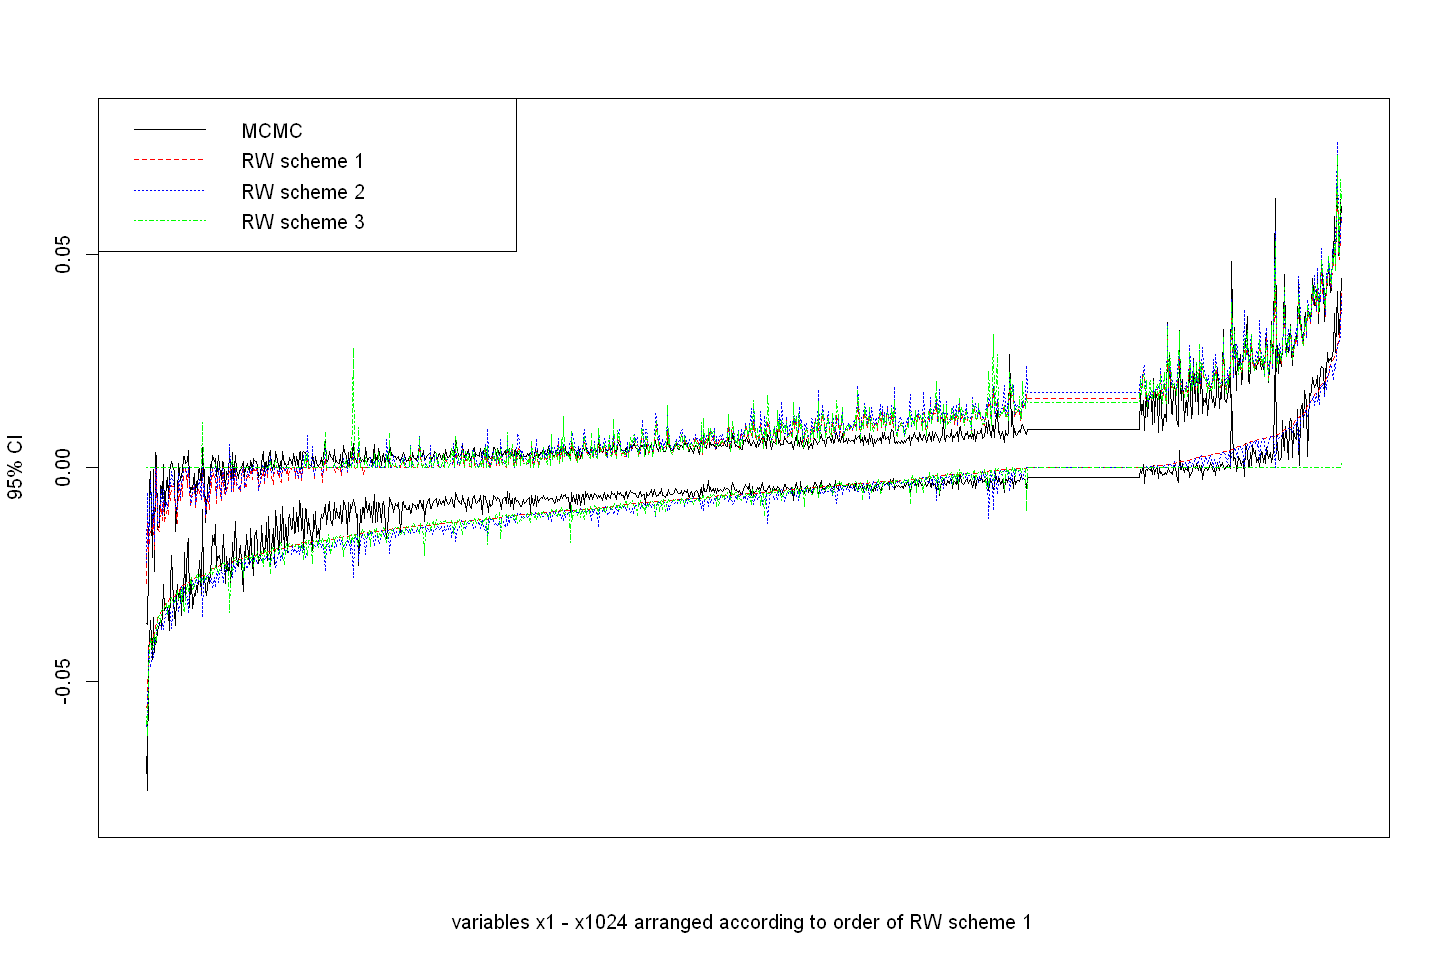

In [29]:
options(repr.plot.width=12, repr.plot.height=8)

CI_iii <- match(sort(CI_RW1$lower),CI_RW1$lower)
plot(1:length(CI_MCMC$lower), CI_MCMC$lower[CI_iii], type = "l", xaxt = "n", ylab = "95% CI", ylim = c(-.08,.08), 
     main = "",  xlab = paste0("variables x1 - x", p, " arranged according to order of ", "RW scheme 1") )
lines(1:length(CI_MCMC$lower), CI_RW1$lower[CI_iii], type = "l", lty = 2, col = "red")
lines(1:length(CI_MCMC$lower), CI_RW2$lower[CI_iii], type = "l", lty = 3, col = "blue")
lines(1:length(CI_MCMC$lower), CI_RW3$lower[CI_iii], type = "l", lty = 4, col = "green")
lines(1:length(CI_MCMC$lower), CI_MCMC$upper[CI_iii], type = "l", lty = 1, col = "black")
lines(1:length(CI_MCMC$lower), CI_RW1$upper[CI_iii], type = "l", lty = 2, col = "red")
lines(1:length(CI_MCMC$lower), CI_RW2$upper[CI_iii], type = "l", lty = 3, col = "blue")
lines(1:length(CI_MCMC$lower), CI_RW3$upper[CI_iii], type = "l", lty = 4, col = "green")
legend('topleft', lty = c(1:4), col = c("black", "red", "blue","green"),
       c("MCMC", "RW scheme 1", "RW scheme 2","RW scheme 3"))

If we plot posterior mean and 95% CI for MCMC samples and RW scheme 1 samples,

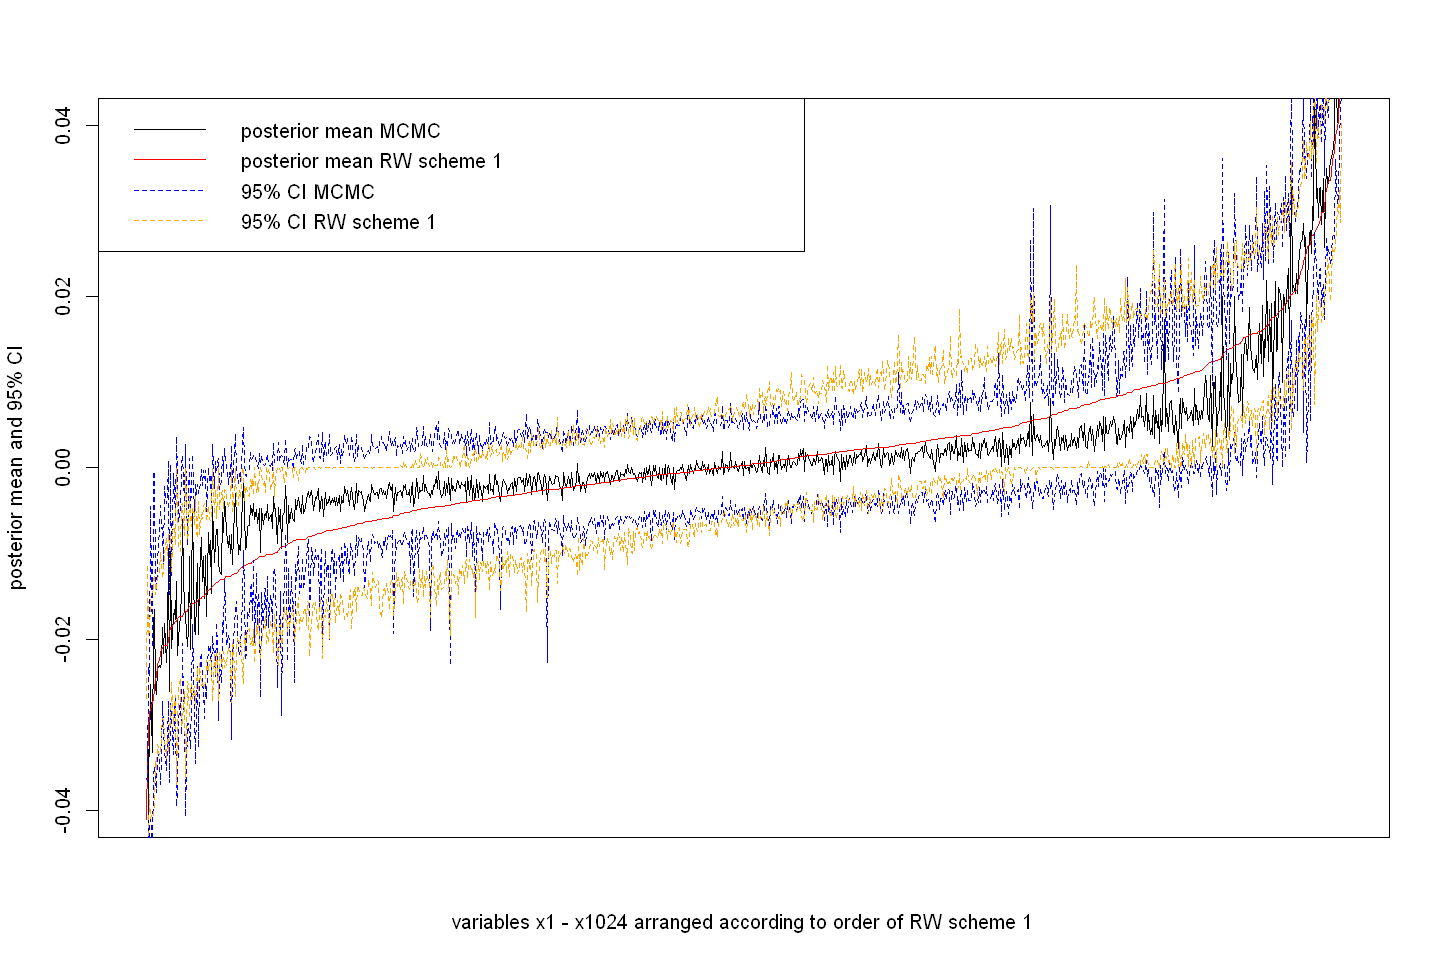

In [31]:
options(repr.plot.width=12, repr.plot.height=8)

CI_iii <- match(sort(mean_RW1),mean_RW1)
plot(1:length(CI_MCMC$lower), mean_MCMC[CI_iii], type = "l", xaxt = "n", 
     ylab = "posterior mean and 95% CI", ylim = c(-.04,.04), main = "",  
     xlab = paste0("variables x1 - x", p, " arranged according to order of ", "RW scheme 1") )
lines(1:length(CI_MCMC$lower), mean_RW1[CI_iii], type = "l", lty = 1, col = "red")
lines(1:length(CI_MCMC$lower), CI_MCMC$upper[CI_iii], type = "l", lty = 2, col = "blue")
lines(1:length(CI_MCMC$lower), CI_RW1$upper[CI_iii], type = "l", lty = 2, col = "orange")
lines(1:length(CI_MCMC$lower), CI_MCMC$lower[CI_iii], type = "l", lty = 2, col = "blue")
lines(1:length(CI_MCMC$lower), CI_RW1$lower[CI_iii], type = "l", lty = 2, col = "orange")
legend('topleft', lty = c(1,1,2,2), col = c("black", "red", "blue","orange"),
       c("posterior mean MCMC", "posterior mean RW scheme 1", 
         "95% CI MCMC", "95% CI RW scheme 1"))

# MSPE

In [32]:
predY_RW1 <- apply( beta_RW1, 1, function(x){
  test_list$X %*% x
})
predY_RW2 <- apply( beta_RW2, 1, function(x){
  test_list$X %*% x
})
predY_RW3 <- apply( beta_RW3, 1, function(x){
  test_list$X %*% x
})

In [33]:
MSPE_RW1 <- apply(predY_RW1, 2, function(x){
  mean( (x - test_list$Y)^2 )
})
MSPE_RW2 <- apply(predY_RW2, 2, function(x){
  mean( (x - test_list$Y)^2 )
})
MSPE_RW3 <- apply(predY_RW3, 2, function(x){
  mean( (x - test_list$Y)^2 )
})

In [34]:
load("MSPE_MCMC.RData")

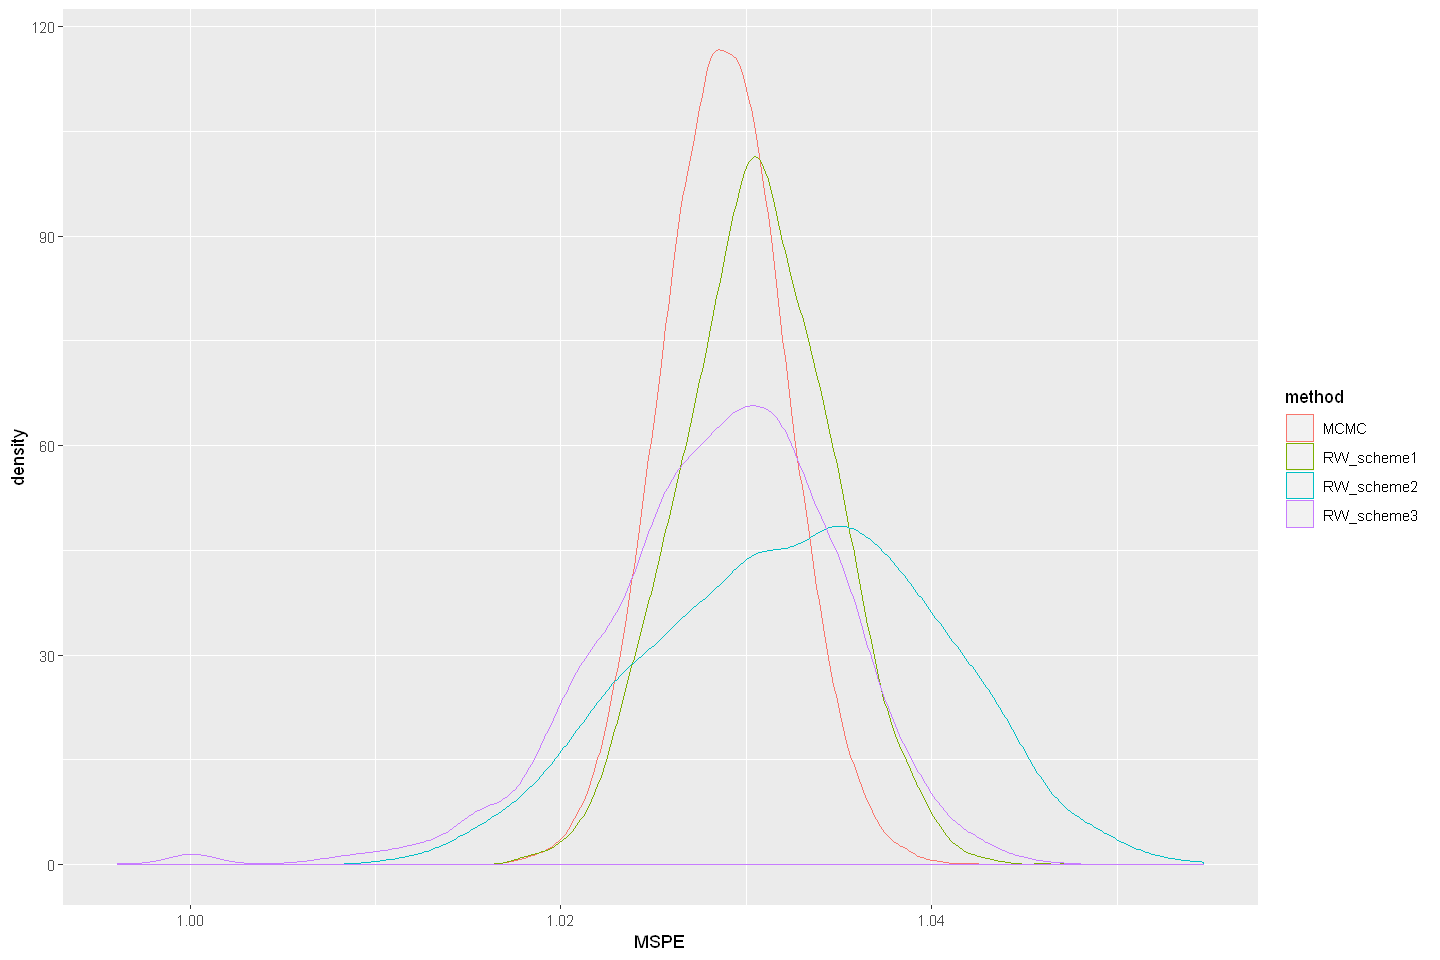

In [35]:
options(repr.plot.width=12, repr.plot.height=8)

dens_plot.func(
  MCMC_vec = MSPE_MCMC, 
  RW1_vec = MSPE_RW1, 
  RW2_vec = MSPE_RW2, 
  RW3_vec = MSPE_RW3,
  xlab = "MSPE"
) 